# Виконання

In [19]:
import scipy.stats as ss
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
# Load data

data = pd.read_csv('D:\BMD\lab7\heart.csv')
data

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


In [21]:
# Feature data columns

data = data[['sex', 'thalach']]
data = data.rename(columns={"thalach": "maxHeartRate"})
data

,sex,maxHeartRate
0,1,150
1,1,187
2,0,172
3,1,178
4,0,163
...,...,...
298,0,123
299,1,132
300,1,141
301,1,115


In [22]:
# Divide data into categories: male/female

maxHeartRate_men = []
maxHeartRate_women = []

for row in data.iterrows():
                                                    # 1 - male, 0 - female
    maxHeartRate_men.append(row[1]['maxHeartRate']) if int(row[1]['sex']) \
    else maxHeartRate_women.append(row[1]['maxHeartRate'])

heartRate_df = [maxHeartRate_men, maxHeartRate_women]

In [23]:
# Check for normality

print('men: ', ss.shapiro(maxHeartRate_men))
print('women: ', ss.shapiro(maxHeartRate_women))

men:  (0.9817501306533813, 0.00871256086975336)
women:  (0.9442283511161804, 0.00047529005678370595)


[Text(0, 0, 'male'), Text(0, 0, 'female')]

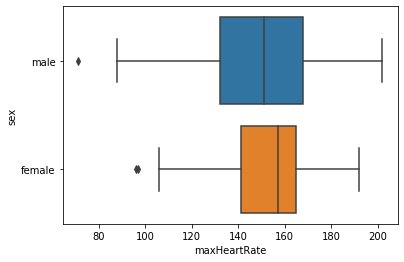

In [24]:
ax = sns.boxplot(data=heartRate_df, orient='h')
ax.set(xlabel='maxHeartRate', ylabel='sex')
ax.set_yticklabels(['male', 'female'])

[Text(0, 0, 'female'), Text(0, 0, 'male')]

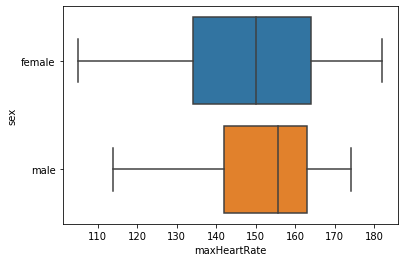

In [25]:
# Remove anomaly values

# Indexes of 5% quantile each side
idx_low_men = int((len(maxHeartRate_men)-1)*0.05)
idx_high_men = int((len(maxHeartRate_men)-1)*0.95)

idx_low_women = int((len(maxHeartRate_women)-1)*0.05)
idx_high_women = int((len(maxHeartRate_women)-1)*0.95)

# Rewrite data arrays without anomaly values
maxHeartRate_men = np.array(sorted(maxHeartRate_men)[idx_low_men:idx_high_men])
maxHeartRate_women = np.array(sorted(maxHeartRate_women)[idx_low_women:idx_high_women])

heartRate_df = [maxHeartRate_men, maxHeartRate_women]

ax = sns.boxplot(data=heartRate_df, orient='h')
ax.set(xlabel='maxHeartRate', ylabel='sex')
ax.set_yticklabels(['female', 'male'])

In [26]:
# 

def LeveneTest(data_array):
    var1 = heartRate_df[0].var()
    var2 = heartRate_df[1].var()
    
    f1 = len(heartRate_df[0])-1
    f2 = len(heartRate_df[1])-1
    
    F = var1 / var2
    
    if var1 < var2:
        F = F**(-1)
        f1, f2 = f2, f1
        
    if f1 > 15:
        f1 = '>15'
        
    if f2 > 20:
        f2 = '>20'
    
    levene_critical = pd.read_excel('D:\BMD\lab7\levene.xlsx',index_col=0, skiprows=1, skipfooter=2, index=False)
    
    level = 'significant' if F < levene_critical[f1][f2] else 'not significant'
    
    return F, level

level = LeveneTest(heartRate_df)[1]
LeveneTest(heartRate_df)

(1.4115166621675863, 'significant')

In [27]:
def Ttest(level, data_array):
    
    sample1 = data_array[0]
    sample2 = data_array[1]
    
    df = sample1.size +  sample2.size - 2
    
    delta_mean = abs( sample1.mean() - sample2.mean() )
    
    if level == 'significant':
        t = delta_mean / np.sqrt(sample1.var() / sample1.size + sample2.var() / sample2.size )
    else:
        t = delta_mean / np.sqrt(\
                                 (sample1.size - 1)*sample1.var()+(sample2.size - 1)*sample2.var() / df *\
                                 (sample1.size + sample2.size/sample1.size * sample2.size)\
                                )
        
    student_critical = pd.read_excel('D:\BMD\lab7\student.xlsx',index_col=0, index=False)
    
    try:
        value_to_cmp = student_critical.loc[df][0]
    except KeyError:
        df = (df, student_critical.index[abs(student_critical.index[:-1]-df).argmin()])
        value_to_cmp = student_critical.loc[df[1]][0]
        
    level = "significant" if t < value_to_cmp else "not significant"
    
    return t, df, level
    
Ttest(level, heartRate_df)

(0.8818723126319626, (269, 250), 'significant')